## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn import linear_model, ensemble, model_selection, metrics, tree, neighbors
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import decomposition, feature_selection, svm, neighbors, datasets, preprocessing, neural_network , dummy
from matplotlib import pyplot

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from collections import Counter

## Load Data

#### Gene Signature Expression Matrix

In [ ]:
Y = pd.read_table('Input/consensus-perts.tsv')
Y.set_index('pert_id', inplace=True)
print( Y.shape)

In [ ]:
Y.head()

#### Pick the fingerprint matrix/matricies

In [106]:
Y = pd.read_table('Input/consensus-perts.tsv')
Y.set_index('pert_id', inplace=True)

X1 = pd.read_table('RDKit_fps/Morg1_BMatrix_map_2018_08.tsv')
X1[X1.columns[0]] = X1[X1.columns[0]].astype(str)
X1 = X1.set_index(X1.columns[0])

X2 = pd.read_table('RDKit_fps/TopologicalTorsion_BMatrix_map_2018_08.tsv')
X2[X2.columns[0]] = X2[X2.columns[0]].astype(str)
X2 = X2.set_index(X2.columns[0])

X3 = pd.read_table('RDKit_fps/AtomPair_BMatrix_map_2018_08.tsv')
X3[X3.columns[0]] = X3[X3.columns[0]].astype(str)
X3 = X3.set_index(X3.columns[0])

X4 = pd.read_table('RDKit_fps/MACCs_BMatrix_map_2018_08.tsv')
X4[X4.columns[0]] = X4[X4.columns[0]].astype(str)
X4 = X4.set_index(X4.columns[0])

X5 = pd.read_table('RDKit_fps/RDKfps2_BMatrix_map_2018_08.tsv')
X5[X5.columns[0]] = X5[X5.columns[0]].astype(str)
X5 = X5.set_index(X5.columns[0])

X6 = pd.read_table('RDKit_fps/Avalon_BMatrix_map_2018_08.tsv')
X6[X6.columns[0]] = X6[X6.columns[0]].astype(str)
X6 = X6.set_index(X6.columns[0])

# X7 = pd.read_table('Output/L1000_Scaffolds_2018_07.tsv')
# X7[X7.columns[0]] = X7[X7.columns[0]].astype(str)
# X7 = X7.set_index(X7.columns[0])
# X7 = X7.T

X = pd.concat([X1, X2, X3, X4, X5, X6], axis = 1, sort=True)
X = X.dropna()
X.head()

,MACC_0,MACC_1,MACC_2,MACC_3,MACC_4,MACC_5,MACC_6,MACC_7,MACC_8,MACC_9,...,Avalon_502,Avalon_503,Avalon_504,Avalon_505,Avalon_506,Avalon_507,Avalon_508,Avalon_509,Avalon_510,Avalon_511
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
BRD-A00267231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
BRD-A00420644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
BRD-A00474148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
BRD-A00520476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [107]:
X.shape

(5435, 2727)

## Only get drugs shared between X and Y

In [108]:
shared_drugs = sorted(list(set(X.index) & set(Y.index)))
X = X.loc[shared_drugs]
Y = Y.loc[shared_drugs]
X = X.values
Y = Y.values

## Dimentionality Reduction

In [109]:
# dr_model = decomposition.LatentDirichletAllocation(n_components=100, learning_method= 'online')
dr_model = decomposition.NMF(n_components=100, init = 'nndsvda')

X_dr = dr_model.fit_transform(X)

In [111]:
X_dr_df = pd.DataFrame(X_dr)
X_dr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.013177,0.000000,0.000000,0.000000,0.000000,0.000000,0.018534,0.030919,0.000000,0.000000,...,0.128043,0.001632,0.00000,0.00000,0.000000,0.000000,0.000000,0.090105,0.020680,0.0
1,0.000000,0.005436,0.003243,0.000000,0.033911,0.026954,0.000000,0.039356,0.005878,0.026192,...,0.010331,0.011071,0.00000,0.07345,0.000000,0.643807,0.000000,0.111425,0.000000,0.0
2,0.083181,0.000000,0.000000,0.000000,0.000000,0.000000,0.007567,0.075123,0.009962,0.009572,...,0.000000,0.000000,0.00000,0.05655,0.020863,0.075262,0.096555,0.060452,0.000000,0.0
3,0.038929,0.000000,0.000000,0.238567,0.164892,0.086148,0.014860,0.110024,0.006600,0.017111,...,0.036064,0.000000,0.00000,0.00000,0.024790,0.000000,0.000000,0.030442,0.153261,0.0
4,0.116757,0.000000,0.128536,0.000000,0.023984,0.000000,0.071647,0.000000,0.000000,0.085157,...,0.111122,0.000000,0.02354,0.00000,0.013660,0.000000,0.000000,0.023620,0.000000,0.0


In [112]:
X = X_dr

In [113]:
X.shape,Y.shape

((5188, 100), (5188, 978))

## Pick the regressor

In [114]:
# regressor = linear_model.MultiTaskLasso()
# regressor = linear_model.MultiTaskElasticNet()
regressor = linear_model.Ridge(fit_intercept=True, normalize=False, copy_X=True, solver='auto')
# regressor = ensemble.RandomForestRegressor(n_estimators = 60, n_jobs = 7)
# regressor = linear_model.BayesianRidge()
# regressor = linear_model.LassoLars() 
# regressor = ensemble.GradientBoostingRegressor(n_estimators = 5, max_depth= 3, min_samples_split= 3, learning_rate= 0.01, loss= 'ls')
# regressor = svm.SVR(degree = 1, epsilon=.01, kernel = 'poly')
# regressor = ensemble.AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
# regressor = neural_network.MLPRegressor(hidden_layer_sizes=(50, ))
# regressor = neighbors.KNeighborsRegressor(n_neighbors=100)
# regressor = dummy.DummyRegressor(strategy = 'median')


## Run the model

In [ ]:
r2ss = []
cv = model_selection.LeaveOneOut()
start = time.time()
for train_idx, test_idx in cv.split(X):
    X_train, Y_train = X[train_idx], Y[train_idx]
    
    X_test, Y_test = X[test_idx], Y[test_idx]
    
    regressor.fit(X_train, Y_train)
    Y_test_pred = regressor.predict(X_test)
    
    r2s = metrics.r2_score(Y_test[0], Y_test_pred[0])
    r2ss.append(r2s)
    
    end = time.time()
    print(end-start)

In [ ]:
#Load a previously saved r2ss
r2ss = np.load('Output/Predicability/All_r2ss_pred.npy')

In [ ]:
#Save R2 scores as a vector
pred_vect_df = pd.DataFrame({'Pert_id':shared_drugs, 'R2_Score':r2ss})
pred_vect_df.to_csv('Output/Pred_vect.csv')

In [ ]:
#Save the r2ss for easier future access
r2ss_pred = np.array(r2ss)
np.save('Output/Predicability/All_r2ss_pred_dummy', r2ss_pred)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


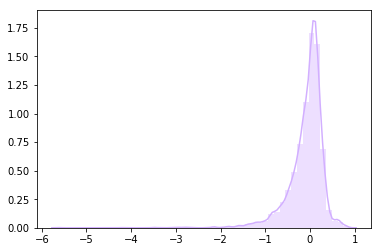

In [98]:
#Plot histogram of r2ss
sns.distplot(r2ss)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 1)

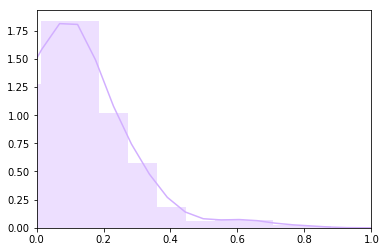

In [99]:
#Plot r2ss between 0 and 1
fig = sns.distplot(r2ss, bins = 75, color='#d2afff')
fig.set_xlim(0,1)

In [100]:
max(r2ss), min(r2ss)

(0.8798493598730603, -5.621905285793909)

In [101]:
#Scale the r2ss to all be between 0 and 1
r2ss_scale_pred = []
r2min = min(r2ss)
r2max = max(r2ss)

for r2 in r2ss:
    scaled = (r2-r2min)/((r2max-r2min))
    r2ss_scale_pred.append(scaled)

In [103]:
Y = r2ss_scale_pred

In [ ]:
r2ss_scaled_pred = np.array(r2ss_scale_pred)
np.save('Output/Predicability/All_r2ss_scaled_pred_dummy', r2ss_scaled_pred)

## Predict the predictability

In [104]:
# pred_regressor = linear_model.Ridge(fit_intercept=True, normalize=False, copy_X=True, solver='auto')
pred_regressor = ensemble.RandomForestRegressor(n_estimators = 300, n_jobs = 7)

pred_r2s = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
start = time.time()
for train_idx, test_idx in cv.split(X):
    X_train, Y_train = X[train_idx], [Y[i] for i in train_idx]
    X_test, Y_test = X[test_idx], [Y[i] for i in test_idx]
    
    pred_regressor.fit(X_train, Y_train)
    Y_test_pred = pred_regressor.predict(X_test)
    
    r2s = metrics.r2_score(Y_test, Y_test_pred)
    pred_r2s.append(r2s)
    end = time.time()
    print(end-start)

9.406721830368042
19.24474596977234
29.975923776626587
39.643054723739624
49.45398497581482


In [105]:
pred_r2s

[0.0004789885007149275,
 0.0926662378694676,
 0.18245812291768826,
 -0.01937094331892819,
 0.06433369691593105]

## Top/Bottom 30 drugs based on r2 values

In [75]:
x = np.array(r2ss)
x_top30 = np.argsort(x)[-30:]
x_bottom30 = np.argsort(x)[:30]

top30 = [shared_drugs[i] for i in x_top30]
bottom30 = [shared_drugs[i] for i in x_bottom30]

In [ ]:
top30, bottom30

In [ ]:
[x[i] for i in x_top30],[x[i] for i in x_bottom330]